In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from scipy.optimize import minimize

class BusBookingPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.robust_scaler = RobustScaler()
        # self.label_encoders = {}
        self.scaler       = StandardScaler()   # for X
        self.y_scaler     = StandardScaler()   # for y
        self.models = {}
        self.feature_importance = {}
        self.weights_dir = './nn_weights'
        self.nn_history = None
        
    def load_and_prepare_data(self, train_path, test_path, transactions_path):
        """Load and prepare all datasets, and record the minimal journey date for trend feature."""
        self.train = pd.read_csv(train_path)
        self.test = pd.read_csv(test_path)
        self.transactions = pd.read_csv(transactions_path)
        
        # parse dates
        for df in (self.train, self.test, self.transactions):
            df['doj'] = pd.to_datetime(df['doj'])
        self.transactions['doi'] = pd.to_datetime(self.transactions['doi']) if 'doi' in self.transactions else None
        
        # record the earliest date for trend
        self.min_doj = self.train['doj'].min()
        
        print(f"Train shape: {self.train.shape}")
        print(f"Test shape: {self.test.shape}")
        print(f"Transactions shape: {self.transactions.shape}")
        
        return self.train, self.test, self.transactions

    def create_time_features(self, df):
        """Comprehensive time-based feature engineering"""
        df = df.copy()
        # Basic calendar
        df['doj_year']   = df['doj'].dt.year
        df['doj_month']  = df['doj'].dt.month
        df['doj_day']    = df['doj'].dt.day
        df['doj_dow']    = df['doj'].dt.dayofweek
        df['is_weekend'] = (df['doj_dow'] >= 5).astype(int)

        # Cyclical encoding
        df['month_sin'] = np.sin(2 * np.pi * df['doj_month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['doj_month'] / 12)
        df['dow_sin']   = np.sin(2 * np.pi * df['doj_dow'] / 7)
        df['dow_cos']   = np.cos(2 * np.pi * df['doj_dow'] / 7)

        # Trend: days since the earliest journey date in training
        if self.min_doj is not None:
            df['days_since_start'] = (df['doj'] - self.min_doj).dt.days
            # optional: a log-scaled trend to capture nonlinear growth
            df['log_days_since_start'] = np.log1p(df['days_since_start'])

        # Days until journey
        if 'doi' in df.columns:
            df['days_until_journey'] = (df['doj'] - df['doi']).dt.days

        return df

    def create_route_features(self, df, transactions):
        """Route-level static and historical aggregates"""
        df = df.copy()
        df['route_key'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)

        # Historical final seatcount stats per route
        final_stats = (
            transactions.groupby(['srcid','destid'])['cumsum_seatcount']
                        .agg(['mean','std'])
                        .rename(columns={'mean':'route_historic_mean', 'std':'route_historic_std'})
                        .reset_index()
        )
        df = df.merge(final_stats, on=['srcid','destid'], how='left')

        # Cumulative cutoffs (DBD=15,21,30)
        for dbd in (15,21,30):
            tmp = (
                transactions[transactions['dbd']==dbd]
                [['doj','srcid','destid','cumsum_seatcount']]
                .rename(columns={'cumsum_seatcount':f'route_cumsum_{dbd}'})
            )
            df = df.merge(tmp, on=['doj','srcid','destid'], how='left')
            df[f'route_cumsum_{dbd}'] = df[f'route_cumsum_{dbd}'].fillna(df['route_historic_mean'])

        return df

    def create_booking_pattern_features(self, df, transactions):
        """Create booking-pattern features using only DBD >= 15 data (merge via route_key)"""
        df = df.copy()
        # Ensure route_key exists
        if 'route_key' not in df.columns:
            df['route_key'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)

        # Filter transactions to DBD >= 15
        txn = transactions[transactions['dbd'] >= 15].copy()
        txn['route_key'] = txn['srcid'].astype(str) + '_' + txn['destid'].astype(str)
        txn.sort_values(['route_key','doj','dbd'], inplace=True)

        # Velocities
        txn['seat_vel']   = txn.groupby(['route_key','doj'])['cumsum_seatcount'].diff().fillna(0)
        txn['search_vel'] = txn.groupby(['route_key','doj'])['cumsum_searchcount'].diff().fillna(0)

        # Last-known snapshot at DBD=15
        snap15 = (
            txn[txn['dbd']==15]
               [['route_key','doj','cumsum_seatcount','cumsum_searchcount']]
               .rename(columns={
                   'cumsum_seatcount':'last_known_seat_count',
                   'cumsum_searchcount':'last_known_search_count'
               })
               .drop_duplicates(['route_key','doj'])
        )
        df = df.merge(snap15, on=['route_key','doj'], how='left')
        df['last_known_seat_count']   = df.get('last_known_seat_count',0).fillna(0)
        df['last_known_search_count'] = df.get('last_known_search_count',0).fillna(0)

        # Rolling average velocities (last 3 points per route_key/doj)
        vel_stats = (
            txn.groupby(['route_key','doj'])['seat_vel']
               .apply(lambda x: x.iloc[-3:].mean() if len(x)>=3 else x.mean())
               .reset_index(name='avg_seat_velocity')
        )
        df = df.merge(vel_stats, on=['route_key','doj'], how='left')
        df['avg_seat_velocity'] = df.get('avg_seat_velocity',0).fillna(0)

        vel_stats_s = (
            txn.groupby(['route_key','doj'])['search_vel']
               .apply(lambda x: x.iloc[-3:].mean() if len(x)>=3 else x.mean())
               .reset_index(name='avg_search_velocity')
        )
        df = df.merge(vel_stats_s, on=['route_key','doj'], how='left')
        df['avg_search_velocity'] = df.get('avg_search_velocity',0).fillna(0)

        return df

 
    def create_interaction_features(self, df):
        """Create interaction and derived features"""
        
        df = df.copy()
        
        if 'last_known_seat_count' in df.columns:
            df['seat_count_weekend_interaction'] = df['last_known_seat_count'] * df['is_weekend']
            df['seat_count_month_interaction'] = df['last_known_seat_count'] * df['doj_month']
        
        if 'srcid_tier' in df.columns and 'destid_tier' in df.columns:
            df['tier_combination'] = df['srcid_tier'].astype(str) + '_' + df['destid_tier'].astype(str)
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in ['last_known_seat_count', 'last_known_search_count']:
            if col in numeric_cols:
                df[f'{col}_log'] = np.log1p(df[col])
                df[f'{col}_sqrt'] = np.sqrt(df[col])
                df[f'{col}_squared'] = df[col] ** 2
        
        return df

    def prepare_features(self, train_df, test_df, transactions_df):
        """Complete feature pipeline with pruning & enhancements"""
        print(" — Time features —")
        train = self.create_time_features(train_df)
        test  = self.create_time_features(test_df)

        print(" — Route features —")
        train = self.create_route_features(train, transactions_df)
        test  = self.create_route_features(test,  transactions_df)

        print(" — Booking pattern —")
        train = self.create_booking_pattern_features(train, transactions_df)
        test  = self.create_booking_pattern_features(test,  transactions_df)

        print(" — Interactions —")
        train = self.create_interaction_features(train)
        test  = self.create_interaction_features(test)

        # Drop zero-importance features
        drop_zero = ['demand_season_interaction','tier_combination']
        train.drop(columns=[c for c in drop_zero if c in train], inplace=True)
        test .drop(columns=[c for c in drop_zero if c in test ], inplace=True)

        return train, test
    
    def encode_categorical_features(self, train_df, test_df):
        """Encode categorical features"""
        print('enofjewofjoawf', self.__dict__)  
        categorical_cols = ['season', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'tier_combination']
        
        for col in categorical_cols:
            if col in train_df.columns:
                le = LabelEncoder()
                combined_data = pd.concat([train_df[col].fillna('Unknown'), test_df[col].fillna('Unknown')])
                le.fit(combined_data.astype(str))
                
                train_df[col] = le.transform(train_df[col].fillna('Unknown').astype(str))
                test_df[col] = le.transform(test_df[col].fillna('Unknown').astype(str))
                
                self.label_encoders[col] = le
        
        return train_df, test_df
    
    def train_models(self, X_train, y_train, X_val, y_val):
        """Train multiple models and ensemble them"""
        models = {}

        print("Training LightGBM...")
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 32,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            # 'lambda_l1': 0.1,           
            # 'lambda_l2': 0.1, 
            'bagging_freq': 5,
            'min_data_in_leaf': 20,
            'bagging_fraction': 0.8, 
            'verbose': -1,
            'random_state': 42
        }
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        models['lgb'] = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        # Training RMSE for LightGBM
        preds_train = models['lgb'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ LightGBM training RMSE: {rmse_train:.4f}")
        # Training RMSE for LightGBM
        preds_val = models['lgb'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ LightGBM Validation RMSE: {rmse_val:.4f}")
        
        print("Training XGBoost...")
        xgb_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': 0.05,
            'max_depth': 7,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            # 'reg_alpha': 0.1,            # add L1 regularization
            # 'reg_lambda': 1.0,           # default L2 regularization
            # 'min_child_weight': 10,      # require at least 10 samples per leaf
            'random_state': 42
        }
        
        models['xgb'] = xgb.XGBRegressor(**xgb_params, n_estimators=500, early_stopping_rounds=50)
        models['xgb'].fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        # Training RMSE for XGBoost
        preds_train = models['xgb'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ XGBoost training RMSE: {rmse_train:.4f}")
        # Validation RMSE for XGBoost
        preds_val = models['xgb'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ XGBoost Validation RMSE: {rmse_val:.4f}")
        
        print("Training Random Forest...")
        models['rf'] = RandomForestRegressor(
            n_estimators=200,
            max_depth=14,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        models['rf'].fit(X_train, y_train)
        # Training RMSE for RF
        preds_train = models['rf'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ RandomForest training RMSE: {rmse_train:.4f}")   
        # Validation RMSE for RF
        preds_val = models['rf'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ RandomForest Validation RMSE: {rmse_val:.4f}")
    
        print("Training Extra Trees...")
        models['et'] = ExtraTreesRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        models['et'].fit(X_train, y_train)

        # Training RMSE for ExtraTrees
        preds_train = models['et'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ ExtraTrees training RMSE: {rmse_train:.4f}")
        # Validation RMSE for ET
        preds_val = models['et'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ ExtraTrees Validation RMSE: {rmse_val:.4f}")
        
        print("Training Linear Models...")
        models['ridge'] = Ridge(alpha=10.0)
        models['ridge'].fit(X_train, y_train)

        preds_train = models['ridge'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ Ridge training RMSE: {rmse_train:.4f}")

        # Validation RMSE for Ridge
        preds_val = models['ridge'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ Ridge Validation RMSE: {rmse_val:.4f}")
        
        models['lasso'] = Lasso(alpha=1.0)
        models['lasso'].fit(X_train, y_train)

        preds_train = models['lasso'].predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
        print(f"→ Lasso training RMSE: {rmse_train:.4f}")
        # Validation RMSE for lasso
        preds_val = models['lasso'].predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        print(f"→ Lasso Validation RMSE: {rmse_val:.4f}")

        self.models = models
        return models

    def retrain_on_full_data(self, X_train, y_train, X_val, y_val):
        """
        Given:
        - models: dict of already-trained models {'lgb': Booster, 'xgb': XGBRegressor, ...}
        - X_train, y_train, X_val, y_val: your train/validation splits

        Returns:
        - models: same dict, but each model .fit() on the combined data.
        """
        # 1) Concatenate train + val
        X_full = pd.concat([X_train, X_val], axis=0)
        y_full = pd.concat([y_train, y_val], axis=0)

        # 2) Loop over each model
        for name, model in self.models.items():
            if hasattr(model, 'fit') and not isinstance(model, lgb.basic.Booster):
                # sklearn-style & XGBRegressor all have .fit(X, y)
                model.fit(X_full, y_full)
            elif isinstance(model, lgb.basic.Booster):
                # LightGBM Booster: rebuild from scratch
                # assume `model.params` and number of rounds = current_iteration()
                params = model.params
                rounds = model.current_iteration()
                train_data = lgb.Dataset(X_full, label=y_full)
                model[name] = lgb.train(
                    params,
                    train_data,
                    num_boost_round=rounds
                )
                print(f"→ Re-trained LightGBM booster for {rounds} rounds")
            else:
                print(f"⚠️ Skipping {name}: no .fit() and not a Booster")
        return self.models

    
    def create_ensemble_predictions(self, X_test):
        """Create ensemble predictions with optimal weights"""
        predictions = {}
        X_test = X_test.astype('float32')
        for name, model in self.models.items():
            if model=='nn':
                continue
            predictions[name] = model.predict(X_test)

        # --- 2) Stack into an (n_samples, n_models) array ---
        model_names = list(predictions.keys())
        pred_array  = np.column_stack([predictions[name] for name in model_names])

        print(model_names, pred_array)
        # --- 3) Simple average ---
        simple_ensemble   = pred_array.mean(axis=1)

        # --- 4) Weighted average ---
        n_models = pred_array.shape[1]
        # weights = [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.81341977e-10, 2.84866269e-10]
        weights = [0.3, 0.3, 0.15, 0.15, 0.05, 0.05]
        weights = [8.36207228e-01, 1.63792772e-01, 0.00000000e+00, 0.00000000e+00, 7.82536471e-14, 8.51662219e-14]
        
        if weights is None:
            # equal weights if none provided
            weights = np.ones(n_models) / n_models
        else:
            weights = np.array(weights, dtype='float32')
            if weights.shape[0] != n_models:
                raise ValueError(f"weights length {weights.shape[0]} "
                                f"!= number of models {n_models}")

        weighted_ensemble = np.average(pred_array, axis=1, weights=weights)

        return {
            'individual': predictions,
            'simple_ensemble': simple_ensemble,
            'weighted_ensemble': weighted_ensemble,
            'model_order': model_names,
            'weights_used': weights
        }     
    
    def evaluate_models(self, X_val, y_val):
        """Evaluate all models on validation set"""
        results = {}
        # pre-cast once if you want:
        X_val_float = X_val.astype('float32')
        # X_val_float = X_val
        edit_df = pd.DataFrame()
        for name, model in self.models.items():
            if name == 'nn':
                # Keras needs float32
                pred = model.predict(X_val_float)
                # Keras returns a (n,1) array
                pred = pred.ravel()
            else:
                # other models can take ints, or you can pass float32 too:
                pred = model.predict(X_val)
            
            edit_df['srcid'] = X_val['srcid']
            edit_df['destid'] = X_val['destid']
            edit_df['diff'] = abs(y_val-pred)

            rmse = np.sqrt(mean_squared_error(y_val, pred))
            mae = mean_absolute_error(y_val, pred)
            r2 = r2_score(y_val, pred)
            
            results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
            print(edit_df)
        
        return edit_df, results
    
    def get_feature_importance(self):
        """Get feature importance from tree-based models"""
        importance_df = pd.DataFrame()
        
        if 'lgb' in self.models:
            importance_df['lgb'] = self.models['lgb'].feature_importance(importance_type='gain')
        
        if 'xgb' in self.models:
            importance_df['xgb'] = self.models['xgb'].feature_importances_
        
        if 'rf' in self.models:
            importance_df['rf'] = self.models['rf'].feature_importances_
        
        importance_df['avg_importance'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('avg_importance', ascending=False)
        
        return importance_df
    
    def get_shap_interactions(self, X_val, top_k=20):
        """
        Compute top SHAP interaction features from supported tree-based models (LightGBM/XGBoost).
        
        Parameters:
            X_val (pd.DataFrame): Validation features
            top_k (int): Number of top interactions to return

        Returns:
            pd.DataFrame: Top SHAP interaction pairs with mean absolute interaction strength
        """
        import shap
        import numpy as np
        import pandas as pd

        model = None
        model_name = None
        
        if 'lgb' in self.models:
            model = self.models['lgb']
            model_name = 'lgb'
        elif 'xgb' in self.models:
            model = self.models['xgb']
            model_name = 'xgb'
        else:
            raise ValueError("No supported tree model found (expected 'lgb' or 'xgb').")

        print(f"Using SHAP interaction values from: {model_name.upper()}")
        explainer = shap.TreeExplainer(model)
        interaction_values = explainer.shap_interaction_values(X_val)

        # Compute mean absolute interaction strength
        interaction_matrix = np.abs(interaction_values).mean(axis=0)

        features = X_val.columns
        interaction_scores = []

        for i in range(len(features)):
            for j in range(i + 1, len(features)):
                interaction_scores.append({
                    'feature_1': features[i],
                    'feature_2': features[j],
                    'interaction_strength': interaction_matrix[i][j]
                })

        interaction_df = pd.DataFrame(interaction_scores)
        interaction_df = interaction_df.sort_values('interaction_strength', ascending=False).reset_index(drop=True)
        
        return interaction_df.head(top_k)


In [18]:
import os

predictor = BusBookingPredictor()

print("predictor is:", predictor)
print("predictor type:", type(predictor))
print("predictor.__dict__:", predictor.__dict__)

train_df, test_df, transactions_df = predictor.load_and_prepare_data(
    'train.csv', 'test_8gqdJqH.csv', 'transactions.csv'
)

train_features, test_features = predictor.prepare_features(train_df, test_df, transactions_df)

print("Encoding categorical features...")
train_features, test_features = predictor.encode_categorical_features(train_features, test_features)

feature_cols = [col for col in train_features.columns 
               if col not in ['doj', 'final_seatcount', 'route_key', 'route_id', 'reverse_route_id'] 
               and col in test_features.columns]
# feature_cols = important_features

# Droping November 2024 Features because of Outliers
train_features = train_features[~((train_features['doj'].dt.year  == 2024) &(train_features['doj'].dt.month == 10))]

X = train_features[feature_cols].fillna(0)
y = train_features['final_seatcount']
X_test = test_features[feature_cols].fillna(0)
print(len(X.columns), len(X_test.columns))

X = X.fillna(X.median())
X_test = X_test.fillna(X.median())

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.01, random_state=69, stratify=None
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


print("Training models...")
models = predictor.train_models(X_train, y_train, X_val, y_val)

print("\nModel Evaluation:")
edit_df, results = predictor.evaluate_models(X_val, y_val)

print("\nTop 20 Most Important Features:")
importance_df = predictor.get_feature_importance() 
importance_df.index = feature_cols
print(importance_df.head(20))

print("\nGenerating predictions...")
ensemble_predictions = predictor.create_ensemble_predictions(X_test)

submission = test_df[['route_key']].copy()
submission['final_seatcount'] = ensemble_predictions['weighted_ensemble']
submission.to_csv('submission_file_NN.csv', index=False)

print("Predictions saved to 'submission_ensemble_trained_file.csv'")

predictor is: <__main__.BusBookingPredictor object at 0x000001E693CCF680>
predictor type: <class '__main__.BusBookingPredictor'>
predictor.__dict__: {'scaler': StandardScaler(), 'robust_scaler': RobustScaler(), 'y_scaler': StandardScaler(), 'models': {}, 'feature_importance': {}, 'weights_dir': './nn_weights', 'nn_history': None}
Train shape: (67200, 4)
Test shape: (5900, 4)
Transactions shape: (2266100, 11)
 — Time features —
 — Route features —
 — Booking pattern —
 — Interactions —
Encoding categorical features...
enofjewofjoawf {'scaler': StandardScaler(), 'robust_scaler': RobustScaler(), 'y_scaler': StandardScaler(), 'models': {}, 'feature_importance': {}, 'weights_dir': './nn_weights', 'nn_history': None, 'train':              doj  srcid  destid  final_seatcount
0     2023-03-01     45      46           2838.0
1     2023-03-01     46      45           2298.0
2     2023-03-01     45      47           2720.0
3     2023-03-01     47      45           2580.0
4     2023-03-01     46  

c:\Users\krish\OneDrive\Desktop\My_Projects\RedBus Hackathon\env\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.43975e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\krish\OneDrive\Desktop\My_Projects\RedBus Hackathon\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.632e+09, tolerance: 8.863e+06
  model = cd_fast.enet_coordinate_descent(


→ Lasso training RMSE: 560.9639
→ Lasso Validation RMSE: 568.7466

Model Evaluation:
lgb: RMSE=299.2810, MAE=221.7641, R2=0.9428
       srcid  destid         diff
2742      46      15    33.343160
18635     45      48   143.825546
62689     21       2   301.623427
40143     45      34   328.690847
15507     48      46   614.371766
...      ...     ...          ...
49375     36      41   377.373536
61328     13      23  1135.805793
49053     16       2    62.414246
11831      7      36   108.674373
52679     41      36   457.887310

[641 rows x 3 columns]
xgb: RMSE=289.8595, MAE=212.7201, R2=0.9463
       srcid  destid         diff
2742      46      15    22.162231
18635     45      48   267.757202
62689     21       2   236.089600
40143     45      34   210.120850
15507     48      46   530.467529
...      ...     ...          ...
49375     36      41   170.405273
61328     13      23  1461.709473
49053     16       2    62.724976
11831      7      36   143.533203
52679     41      36 

In [15]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


preds_val = [
    models['lgb'].predict(X_val),
    models['xgb'].predict(X_val),
    models['rf'].predict(X_val),
    models['et'].predict(X_val),
    models['ridge'].predict(X_val),
    models['lasso'].predict(X_val),
]

def objective(w):
    ens = sum(w[i] * preds_val[i] for i in range(len(w)))
    return np.sqrt(mean_squared_error(y_val, ens))

# constraints: weights sum to 1, and 0 <= w_i <= 1
cons   = ({'type':'eq',   'fun': lambda w: w.sum() - 1})
bounds = [(0,1)] * len(preds_val)
init   = np.ones(len(preds_val)) / len(preds_val)

res = minimize(objective, init, bounds=bounds, constraints=cons)
opt_weights = res.x
print("Optimized weights:", opt_weights)

Optimized weights: [6.00602104e-01 3.99397896e-01 4.19723321e-13 6.82485736e-13
 0.00000000e+00 0.00000000e+00]


In [17]:
# Assuming you still have preds_val and y_val in scope:

# 1) Using your objective function:
opt_rmse = objective(opt_weights)
print(f"Optimized ensemble validation RMSE: {opt_rmse:.4f}")

# 2) Or manually:
import numpy as np
from sklearn.metrics import mean_squared_error
opt_weights2 = [8.36207228e-01, 1.63792772e-01, 0.00000000e+00, 0.00000000e+00, 7.82536471e-14, 8.51662219e-14]
# opt_weights2 = [0.3, 0.3, 0.15, 0.15, 0.05, 0.05]
# Build the ensemble predictions
ens_val = sum(opt_weights2[i] * preds_val[i] for i in range(len(preds_val)))
# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, ens_val))
print(f"Optimized ensemble validation RMSE: {rmse:.4f}")


Optimized ensemble validation RMSE: 323.6652
Optimized ensemble validation RMSE: 324.5308


In [195]:
top_interactions_df = predictor.get_shap_interactions(X_val = X_val, top_k=15)
print(top_interactions_df)

Using SHAP interaction values from: LGB
              feature_1                feature_2  interaction_strength
0   route_historic_mean       route_historic_std             73.559339
1    route_historic_std  last_known_search_count             43.416999
2   route_historic_mean  last_known_search_count             26.066956
3    route_historic_std          route_cumsum_15             22.705300
4       route_cumsum_15  last_known_search_count             19.610914
5             doj_month                  doj_day             17.744843
6              doj_year                doj_month             13.229481
7   route_historic_mean          route_cumsum_15             13.206152
8                 srcid                  dow_cos             12.884427
9                 srcid       route_historic_std             12.875416
10               destid                  dow_cos             12.629189
11            month_cos  last_known_search_count             12.600225
12              dow_sin       route_h

c:\Users\krish\OneDrive\Desktop\My_Projects\RedBus Hackathon\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


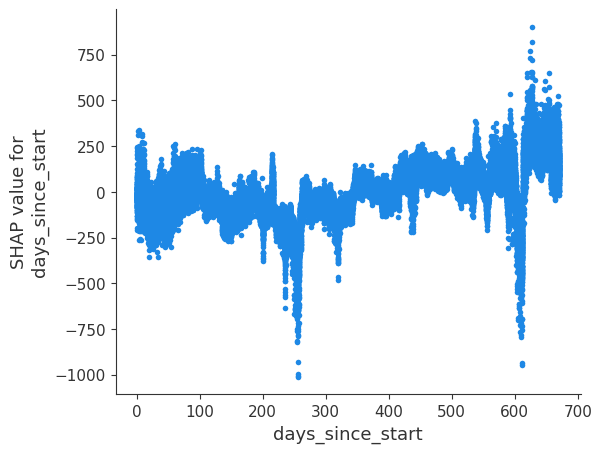

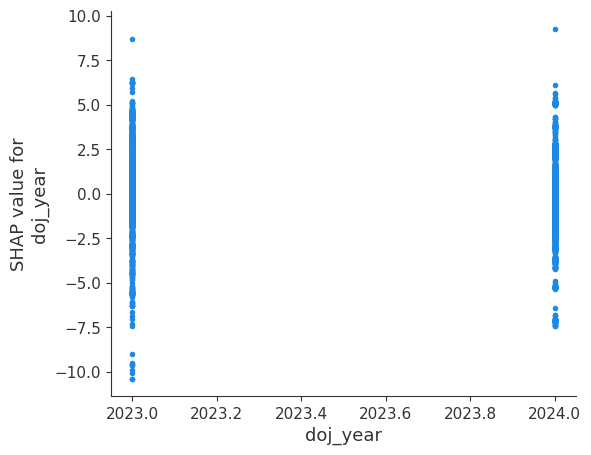

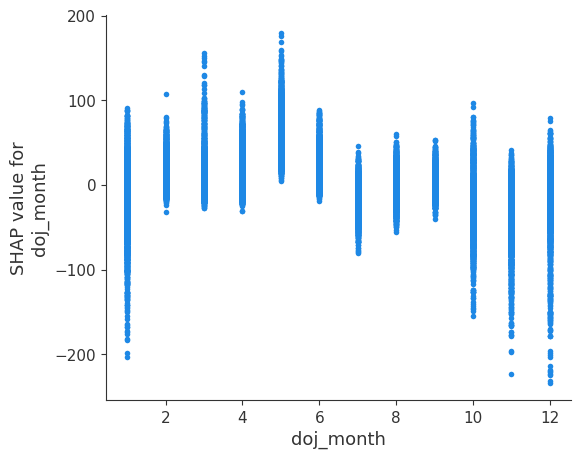

In [5]:
import shap

# 1) Wrap your trained LightGBM model
explainer11  = shap.TreeExplainer(predictor.models['lgb'])
shap_vals11   = explainer11.shap_values(X_train)

# shap.figure(figsize=(15,6))
# 2) Make the dependence plot for the trend
shap.dependence_plot(
    'days_since_start',
    shap_vals11,
    X_train,
    interaction_index=None,
    show=True
)
shap.dependence_plot(
    'doj_year',
    shap_vals11,
    X_train,
    interaction_index=None,
    show=True
)
shap.dependence_plot(
    'doj_month',
    shap_vals11,
    X_train,
    interaction_index=None,
    show=True
)


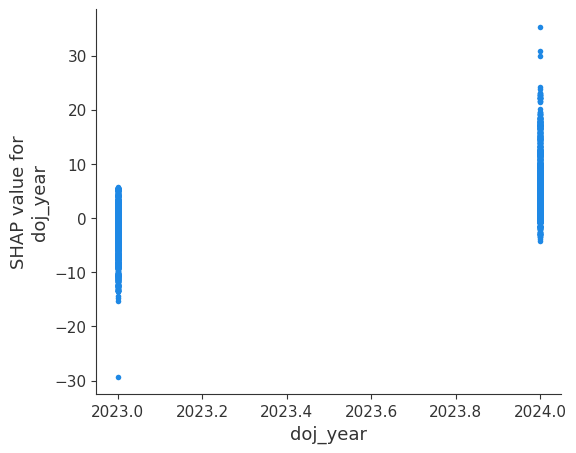

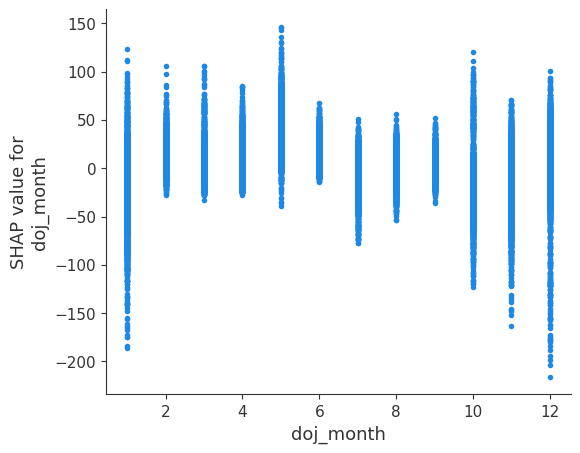

In [ ]:
shap.dependence_plot('doj_year', shap_vals, X_train, interaction_index=None)

shap.dependence_plot('doj_month', shap_vals, X_train, interaction_index=None)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# assume `models['lgb']` is your trained LightGBM regressor (wrapped as sklearn Estimator)
# and X_train is your feature DataFrame

# 1) for year:
PartialDependenceDisplay.from_estimator(
    models['lgb'], 
    X_train, 
    features=['doj_year'],
    kind='average',
    grid_resolution=5
)
 
# 2) for month:
PartialDependenceDisplay.from_estimator(
    models['lgb'], 
    X_train, 
    features=['doj_month'],
    kind='average',
    grid_resolution=12
)


In [206]:
top_interactions_df.head()

,feature_1,feature_2,interaction_strength
0,route_cumsum_seatcount_std,route_cumsum_seatcount_median,27.846051
1,route_cumsum_seatcount_std,avg_search_velocity,22.979875
2,route_cumsum_seatcount_std,avg_seat_velocity,20.296871
3,avg_search_velocity,std_search_velocity,14.942257
4,doj_dayofweek_sin,route_cumsum_seatcount_std,14.429650


In [16]:
import holidays
from datetime import date
import pandas as pd

india_holidays = holidays.country_holidays('IN', years=range(2023, 2024))

holidays_list = [{"Date": str(day), "Holiday": name} for day, name in india_holidays.items()]
holidays_df = pd.DataFrame(holidays_list).sort_values(by='Date', )

print(holidays_df)



          Date             Holiday
0   2023-01-26        Republic Day
8   2023-02-18     Maha Shivaratri
7   2023-04-04     Mahavir Jayanti
14  2023-04-07         Good Friday
12  2023-04-22          Id-ul-Fitr
3   2023-05-05      Buddha Purnima
13  2023-06-29              Bakrid
10  2023-07-29            Muharram
1   2023-08-15    Independence Day
5   2023-09-07         Janmashtami
11  2023-09-28       Milad-un-Nabi
2   2023-10-02      Gandhi Jayanti
6   2023-10-24            Dussehra
4   2023-11-12              Diwali
9   2023-11-27  Guru Nanak Jayanti
15  2023-12-25           Christmas
